## 1. Load Essential Libraries

In [5]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## 2. Dataset

### 2.1. Download Dataset

In [7]:
# Download data
#import requests
#request = requests.get("https://drive.google.com/uc?export=download&id=1wHt8PsMLsfX5yNSqrt2fSTcb8LEiclcf")
#with open("data.zip", "wb") as file:
#    file.write(request.content)



In [5]:
# Unzip data
import zipfile
with zipfile.ZipFile('data.zip') as zip:
    zip.extractall('data')

### 2.2. Load Train Data

The train data has 2 files, each containing 1700 complaining/non-complaining tweets. Every tweets in the data contains at least a hashtag of an airline.

We will load the train data and label it. Because we use only the text data to classify, we will drop unimportant columns and only keep id, tweet and label columns.

In [7]:
 # Load data and set labels
data_complaint = pd.read_csv('data/complaint1700.csv')
data_complaint['label'] = 0
data_non_complaint = pd.read_csv('data/noncomplaint1700.csv')
data_non_complaint['label'] = 1

# Concatenate complaining and non-complaining data
data = pd.concat([data_complaint, data_non_complaint], axis=0).reset_index(drop=True)

# Drop 'airline' column
data.drop(['airline'], inplace=True, axis=1)

# Display 5 random samples
data.sample(5)

,id,tweet,label
291,95181,@JLJeffLewis @AmericanAir no excuse for lost l...,0
755,20845,I thought airport wi-fi was ridiculous until I...,0
2096,32473,@DanniAllen14 @united @RunLikeAGirl_ca @just_t...,1
432,165082,My @united flight to LA had no electricity for...,0
479,37552,Poop. _@stevethebikeguy: @JetBlue announces ne...,0


We will randomly split the entire training data into two sets: a train set with 90% of the data and a validation set with 10% of the data. We will perform hyperparameter tuning using cross-validation on the train set and use the validation set to compare models.

In [8]:
from sklearn.model_selection import train_test_split

X = data.tweet.values
y = data.label.values

X_train, X_val, y_train, y_val =\
    train_test_split(X, y, test_size=0.1, random_state=2022)

## 2.3. Load Test Data

The test data contains 4555 examples with no label. About 300 examples are non-complaining tweets. Our task is to identify their id and examine manually whether our results are correct.

In [9]:
# Load test data
test_data = pd.read_csv('data/test_data.csv')

# Keep important columns
test_data = test_data[['id', 'tweet']]

# Display 5 samples from the test data
test_data.sample(5)

,id,tweet
1502,58081,@theJMcCray Unfortunately flight prices have s...
3572,134867,Ugh trying to get info on the @Delta website i...
4110,156758,@united Nothing like being on hold for 30 minu...
2586,98990,.@united far too many avoidable fails from ATL...
1739,67130,"Apparently bags are en route, but having to wa..."


## 3. Set up GPU for training

In [10]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


## C - Baseline: TF-IDF + Naive Bayes Classifier

In this baseline approach, first we will use TF-IDF to vectorize our text data. Then we will use the Naive Bayes model as our classifier.

### 1. Data Preparation

#### 1.1. Preprocessing

In the bag-of-words model, a text is represented as the bag of its words, disregarding grammar and word order. Therefore, we will want to remove stop words, punctuations and characters that don't contribute much to the sentence's meaning.

In [11]:
import nltk
# Uncomment to download "stopwords"
from nltk.corpus import stopwords

def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

### 1.2. TF-IDF Vectorizer

In [12]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocess text
X_train_preprocessed = np.array([text_preprocessing(text) for text in X_train])
X_val_preprocessed = np.array([text_preprocessing(text) for text in X_val])

# Calculate TF-IDF
tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_val_tfidf = tf_idf.transform(X_val_preprocessed)

Wall time: 18.4 s


## 2. Train Naive Bayes Classifier

### 2.1. Hyperparameter Tuning

We will use cross-validation and AUC score to tune hyperparameters of our model. The function get_auc_CV will return the average AUC score from cross-validation.

In [13]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def get_auc_CV(model):
    """
    Return the average AUC score from cross-validation.
    """
    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    # Get AUC scores
    auc = cross_val_score(
        model, X_train_tfidf, y_train, scoring="roc_auc", cv=kf)

    return auc.mean()

The MultinominalNB class only have one hypterparameter - alpha. The code below will help us find the alpha value that gives us the highest CV AUC score.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass alpha=1.0 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass alpha=1.1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass alpha=1.2000000000000002 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass alpha=1.3000000000000003 as keyw

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass alpha=4.100000000000003 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass alpha=4.200000000000003 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass alpha=4.3000000000000025 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass alph

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass alpha=7.2000000000000055 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass alpha=7.300000000000006 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass alpha=7.400000000000006 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass alph

Best alpha:  1.0


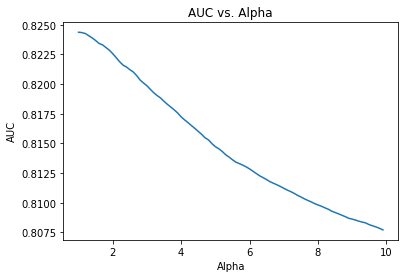

In [14]:
from sklearn.naive_bayes import MultinomialNB

res = pd.Series([get_auc_CV(MultinomialNB(i))
                 for i in np.arange(1, 10, 0.1)],
                index=np.arange(1, 10, 0.1))

best_alpha = np.round(res.idxmax(), 2)
print('Best alpha: ', best_alpha)

plt.plot(res)
plt.title('AUC vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.show()

### 2.2. Evaluation on Validation Set

To evaluate the performance of our model, we will calculate the accuracy rate and the AUC score of our model on the validation set.

In [15]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

By combining TF-IDF and the Naive Bayes algorithm, we achieve the accuracy rate of 76.47% on the validation set. This value is the baseline performance and will be used to evaluate the performance of our fine-tune BERT model.

AUC: 0.8663
Accuracy: 76.47%


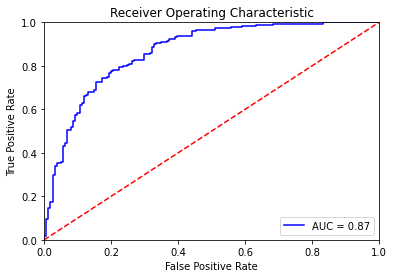

In [16]:
# Compute predicted probabilities
nb_model = MultinomialNB(alpha=1.8)
nb_model.fit(X_train_tfidf, y_train)
probs = nb_model.predict_proba(X_val_tfidf)

# Evaluate the classifier
evaluate_roc(probs, y_val)

## D - Fine-tuning BERT

### Tokenization and Input Formatting

In [17]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [18]:
# Print sentence 0
print('Original: ', X[0])
print('Processed: ', text_preprocessing(X[0]))

Original:  @united I'm having issues. Yesterday I rebooked for 24 hours after I was supposed to fly, now I can't log on &amp; check in. Can you help?
Processed:  I'm having issues. Yesterday I rebooked for 24 hours after I was supposed to fly, now I can't log on & check in. Can you help?


### BERT Tokenizer

In [19]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

Before tokenizing, we need to specify the maximum length of our sentences.

In [20]:
# Concatenate train data and test data
all_tweets = np.concatenate([data.tweet.values, test_data.tweet.values])

# Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  68


In [21]:
# Specify `MAX_LEN`
MAX_LEN = 64

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:  @united I'm having issues. Yesterday I rebooked for 24 hours after I was supposed to fly, now I can't log on &amp; check in. Can you help?
Token IDs:  [101, 1045, 1005, 1049, 2383, 3314, 1012, 7483, 1045, 2128, 8654, 2098, 2005, 2484, 2847, 2044, 1045, 2001, 4011, 2000, 4875, 1010, 2085, 1045, 2064, 1005, 1056, 8833, 2006, 1004, 4638, 1999, 1012, 2064, 2017, 2393, 1029, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenizing data...


C:\ProgramData\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2184: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


### Create PyTorch DataLoader

create an iterator for dataset using the torch DataLoader class. This will help save on memory during training and boost the training speed.

In [22]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

### Train Our Model

### Create BertClassifier

BERT-base consists of 12 transformer layers, each transformer layer takes in a list of token embeddings, and produces the same number of embeddings with the same hidden size (or dimensions) on the output. The output of the final transformer layer of the [CLS] token is used as the features of the sequence to feed a classifier.

The transformers library has the BertForSequenceClassification class which is designed for classification tasks. However, we will create a new class so we can specify our own choice of classifiers.

Below we will create a BertClassifier class with a BERT model to extract the last hidden layer of the [CLS] token and a single-hidden-layer feed-forward neural network as our classifier.

In [27]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased',cache_dir=os.path.join(os.getcwd(),"bert-base-uncased_cache"))

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

Wall time: 0 ns


### Optimizer & Learning Rate Scheduler

To fine-tune our Bert Classifier, we need to create an optimizer. The authors recommend following hyper-parameters:

 - Batch size: 16 or 32
 - Learning rate (Adam): 5e-5, 3e-5 or 2e-5
 - Number of epochs: 2, 3, 4
Huggingface provided the  [run_glue.py ](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109) script, an examples of implementing the transformers library. In the script, the AdamW optimizer is used

In [28]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-6,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=total_steps, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

### Training Loop

We will train our Bert Classifier for 4 epochs. In each epoch, we will train our model and evaluate its performance on the validation set. In more details, we will:

Training:

 - Unpack our data from the dataloader and load the data onto the GPU
 - Zero out gradients calculated in the previous pass
 - Perform a forward pass to compute logits and loss
 - Perform a backward pass to compute gradients (loss.backward())
 - Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
 - Update the model's parameters (optimizer.step())
 - Update the learning rate (scheduler.step())

Evaluation:

 - Unpack our data and load onto the GPU
 - Forward pass
 - Compute loss and accuracy rate over the validation set

In [29]:
import random
import time
from torch.utils.tensorboard import SummaryWriter  
# tensorboard to show losses
writer = SummaryWriter('./loss/bert_fine_total_steps_07Dec')
# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            writer.add_scalar('loss/train_loss', avg_train_loss, epoch_i)
            writer.add_scalar('loss/val_loss', val_loss, epoch_i)
            writer.add_scalar('matrix/val_accuracy', val_accuracy, epoch_i)
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        print('logits ,b_labels ')
        print(logits)
        print(b_labels)
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        #accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        accuracy = (preds == b_labels).cpu().numpy().mean() 
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

### start training our BertClassifier!

In [30]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=4)
train(bert_classifier, train_dataloader, val_dataloader, epochs=4, evaluation=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.698128   |     -      |     -     |  151.34  
   1    |   40    |   0.693965   |     -      |     -     |  143.62  
   1    |   60    |   0.699480   |     -      |     -     |  144.90  
   1    |   80    |   0.697797   |     -      |     -     |  153.10  
   1    |   95    |   0.687750   |     -      |     -     |  109.23  
----------------------------------------------------------------------
logits ,b_labels 
tensor([[-0.0404,  0.1625],
        [ 0.0204,  0.1580],
        [-0.0517,  0.0666],
        [-0.0967,  0.1350],
        [ 0.0740,  0.1870],
        [-0.0277,  0.2401],
        [-0.0021,  0.1718],
        [ 0.0303,  0.1822],
        [-0.0687,  0.0988],
        [-0.1643,  0.1059],
        [ 0.0614,  0.2154],
        [-0.0818,  0.1480],
        [ 0.0051,  0.2482],
        [-0.0311,  0.0280],
        [

logits ,b_labels 
tensor([[ 0.0104,  0.1327],
        [ 0.0254,  0.1029],
        [-0.0666,  0.0044],
        [-0.0038,  0.1195],
        [ 0.0919,  0.1951],
        [-0.0441,  0.1087],
        [-0.0513,  0.1242],
        [-0.0981,  0.1814],
        [-0.1625,  0.0837],
        [-0.0300,  0.0531],
        [-0.0493,  0.1002],
        [-0.1428,  0.1769],
        [ 0.1038,  0.2324],
        [-0.0192,  0.1382],
        [ 0.0406,  0.1113],
        [ 0.0819,  0.1069],
        [-0.0850,  0.0793],
        [-0.0324,  0.1481],
        [ 0.0194,  0.1277],
        [-0.0076,  0.1973],
        [ 0.0495,  0.0400],
        [-0.0772,  0.1427],
        [-0.0339,  0.0115],
        [-0.0281,  0.1767],
        [-0.0388,  0.1594],
        [ 0.0454,  0.1399],
        [-0.0506,  0.2236],
        [-0.0093,  0.1189],
        [-0.0619,  0.1202],
        [ 0.1010,  0.1737],
        [ 0.0209,  0.0949],
        [-0.0620,  0.2042]])
tensor([1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
     

logits ,b_labels 
tensor([[ 0.3336, -0.2089],
        [ 0.1189,  0.1790],
        [ 0.1755,  0.0768],
        [-0.1283,  0.0828],
        [ 0.1090,  0.0498],
        [ 0.1228,  0.0288],
        [ 0.0915,  0.1518],
        [-0.0554,  0.3137],
        [ 0.0231,  0.2054],
        [ 0.1114, -0.0945],
        [ 0.2030, -0.1574],
        [ 0.2284,  0.0126],
        [ 0.0761,  0.2282],
        [ 0.2043, -0.0366],
        [ 0.0351,  0.0835],
        [-0.1174,  0.0986],
        [ 0.1377,  0.0251],
        [ 0.0645, -0.0491],
        [-0.1420,  0.1033],
        [-0.0847,  0.0937],
        [ 0.2606, -0.1413],
        [ 0.0797, -0.0541],
        [ 0.1331,  0.0327],
        [ 0.3788, -0.0103],
        [-0.0612,  0.0994],
        [ 0.0175,  0.0276],
        [-0.1316,  0.2490],
        [ 0.1598, -0.1571],
        [ 0.2938, -0.0884],
        [ 0.1674, -0.0463],
        [ 0.2674, -0.0498],
        [ 0.1589, -0.2177]])
tensor([1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
     

logits ,b_labels 
tensor([[ 0.0848,  0.0421],
        [-0.2216,  0.3174],
        [ 0.2261, -0.1824],
        [-0.3672,  0.5072],
        [-0.1879,  0.2696],
        [ 0.5965, -0.6115],
        [ 0.2587, -0.4368],
        [ 0.5297, -0.4928],
        [ 0.4041, -0.4495],
        [ 0.6548, -0.6507],
        [ 0.6150, -0.5589],
        [-0.3777,  0.5304],
        [ 0.0669, -0.0227],
        [-0.1899,  0.2836],
        [ 0.3762, -0.1919],
        [-0.2586,  0.4714],
        [ 0.3206, -0.2398],
        [ 0.0867,  0.0439],
        [ 0.4546, -0.2676],
        [-0.3251,  0.2077],
        [-0.1036,  0.0498],
        [-0.2384,  0.3599],
        [-0.2724,  0.4785],
        [ 0.2194, -0.1372],
        [-0.3308,  0.3105],
        [ 0.1986, -0.3413],
        [-0.0137,  0.3426],
        [-0.2869,  0.2817],
        [-0.1654,  0.2653],
        [ 0.2892, -0.3921],
        [-0.0433,  0.2703],
        [ 0.2599, -0.1494]])
tensor([1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
     

logits ,b_labels 
tensor([[-0.1767,  0.1481],
        [ 0.1039, -0.2660],
        [ 0.0636, -0.0608],
        [-0.4058,  0.5462],
        [-0.0288,  0.1485],
        [ 0.0943,  0.1232],
        [-0.1685,  0.2136],
        [-0.0582,  0.2088],
        [ 0.5744, -0.5206],
        [-0.3690,  0.4903],
        [ 0.0923, -0.0255],
        [ 0.0113, -0.0332],
        [ 0.1947, -0.1411],
        [ 0.4232, -0.3819],
        [-0.2495,  0.4334],
        [-0.3094,  0.3455],
        [ 0.5834, -0.6836],
        [-0.3556,  0.4126],
        [ 0.4488, -0.4994],
        [-0.0333,  0.1879]])
tensor([1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0])
   3    |    -    |   0.623951   |  0.569033  |   0.75    |  727.84  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   4    |   20    |   0.564449   |     -      |     -     |  150.94 

logits ,b_labels 
tensor([[-0.6635,  0.6719],
        [ 0.4347, -0.5475],
        [ 0.5383, -0.6291],
        [ 1.0234, -1.1327],
        [-0.5895,  0.4072],
        [ 0.3355, -0.4987],
        [-0.7648,  0.7000],
        [ 0.8799, -1.0579],
        [ 0.6758, -0.8550],
        [-0.7199,  0.8586],
        [-0.1611,  0.0224],
        [ 0.6269, -0.6847],
        [-0.2867,  0.5272],
        [ 0.1569, -0.0529],
        [ 0.1824, -0.0310],
        [-0.8140,  0.8610],
        [ 0.4952, -0.5149],
        [ 0.1201, -0.0312],
        [-0.2919,  0.0529],
        [ 0.5106, -0.5493],
        [-0.6210,  0.4379],
        [ 0.2469, -0.1802],
        [ 1.0534, -0.8933],
        [ 0.9468, -0.9361],
        [-0.4557,  0.6191],
        [ 0.3731, -0.5951],
        [-0.0580,  0.0333],
        [ 1.1369, -1.1450],
        [-0.6786,  0.7365],
        [ 0.5900, -0.5346],
        [-0.4130,  0.1560],
        [ 0.4603, -0.6279]])
tensor([1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
     

### Evaluation on Validation Set

The prediction step is similar to the evaluation step that we did in the training loop, but simpler. We will perform a forward pass to compute logits and apply softmax to calculate probabilities.

In [31]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

AUC: 0.8439
Accuracy: 72.35%


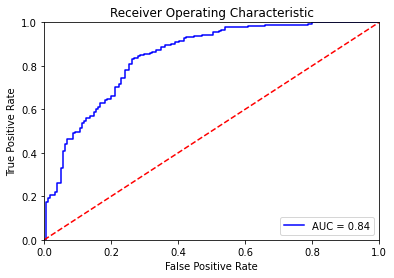

In [32]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val)

### Train Our Model on the Entire Training Data

### Predictions on Test Set

In [33]:
test_data.sample(5)

,id,tweet
471,18654,Friends and family: Never fly @JetBlue. Absol...
1971,76265,@DeltaAssist @rogerioad I never have had a pro...
23,672,First flight in weeks. Counting on you @Americ...
2702,103263,"""@USAirways: You know that we can__t stay no m..."
135,5137,@southwestair Here at SA Airport watching the ...


In [34]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(test_data.tweet)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Tokenizing data...


C:\ProgramData\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2184: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## Predictions

There are about 300 non-negative tweets in our test set. Therefore, we will keep adjusting the decision threshold until we have about 300 non-negative tweets.

The threshold we will use is 0.8, meaning that tweets with a predicted probability greater than 97.0% will be predicted positive. This value is very high compared to the default 0.5 threshold.

After manually examining the test set, I find that the sentiment classification task here is even difficult for human. Therefore, a high threshold will give us safe predictions.

In [38]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

# Get predictions from the probabilities
threshold = 0.8
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("Number of tweets predicted non-negative: ", preds.sum())

Number of tweets predicted non-negative:  291


Now we will examine 20 random tweets from our predictions. 17 of them are correct, showing that the BERT Classifier acquires about 0.85 precision rate.

In [36]:
output = test_data[preds==1]
list(output.sample(20).tweet)

["T'was fun seeing you this month bae @JetBlue   Cant wait to see you next month!!!!!! #operationhotwinter #winteriscoming #imnotgoingtobecold",
 '@Colbyjames09 @AmericanAir COLBY I miss taking meet and greet pics with you_',
 '@DougBenson @united @ComedyZoneCLT Dammmmmmmn. Time for some edibles while you wait.',
 'Hate being away from my family but @AlaskaAir  flying all 6 of us to Cali for $334 round trip sure makes vacations better. Thanks #MVP',
 'Thanks @VirginAmerica for letting me switch to an earlier flight at no charge! More family time in NYC!',
 "@KassieDePaiva @JetBlue can't wait :)!! Love ya Kassie xoxo",
 "JFK to LAX on @VirginAmerica ! Let's do this!! can't wait to see my friends and family soon..._",
 '@richeisen @united Rich, fly @AmericanAir zero problems &amp; I fly weekly! #firstworldproblems',
 "@mary_c_moore What the heck? Isn't the weather perfect at both cities? Boo.   FWIW, I love @VirginAmerica",
 "SFO for a weekend getaway in just a few short weeks! RT @Alask